In [1]:
import os
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

In [2]:
# Import all measurements from the `./measurements` directory. Each measurement file
# is read into a numpy array (column-first) and added to the `meas_dict` (keys are
# filenames with extentions removed).
meas_dict = {}
suffix, sep = 'txt', ','
for fname in glob.glob(f'./measurements/*filtered*.{suffix}'):
    with open(fname) as file:
        meas = [[float(el) for el in row.rstrip().split(sep)]
                for row in file.readlines()]
        meas_name, _ = str.rsplit(os.path.basename(fname), '.', maxsplit=1)
        meas_dict[meas_name] = np.array(meas).T

In [3]:
# Unpack flattened data
a, = meas_dict['diff-filtered']
Δx_px_1, Δy_px_1, t_1, _ = a[0::8], a[1::8], a[2::8], a[3::8]
Δx_px_2, Δy_px_2, t_2, _ = a[4::8], a[5::8], a[6::8], a[7::8]

# Convert from pixel units
r = 1e-6/0.813 # m/px
Δx_1, Δy_1 = r * Δx_px_1, r * Δy_px_1
Δx_2, Δy_2 = r * Δx_px_2, r * Δy_px_2

v_1 = np.array([Δx_1 / t_1, Δy_1 / t_1])
v_2 = np.array([Δx_2 / t_2, Δy_2 / t_2])
v_x1, v_y1 = v_1
v_x2, v_y2 = v_2

# Constants
q_0_theor = 1.6022e-19
g = 9.807
p = 102e5
T = 273.15 + 23
M_zr = 28.96 # kg/kmol
R = 8314 # J/K kmol 
ρ_zr = p*M_zr / (R*T)
η_zr = 18.3e-6

ρ = 973
d, Δd = 5e-3, 0.1e-3
U = 245

In [28]:
ρ, ρ_zr, 1e6 * η_zr

(973, 119.97119151312017, 18.3)

In [16]:
# Direction vectors
n_1 = v_1 / np.sqrt(np.sum(v_1**2, axis=0))
n_2 = v_2 / np.sqrt(np.sum(v_2**2, axis=0))

# Average direction
n = np.mean(
    np.concatenate(
        [n_1, np.sign(n_2[0,:]) * n_2],
        axis=1),
    axis=1)
n = n / np.sqrt(np.sum(n**2))

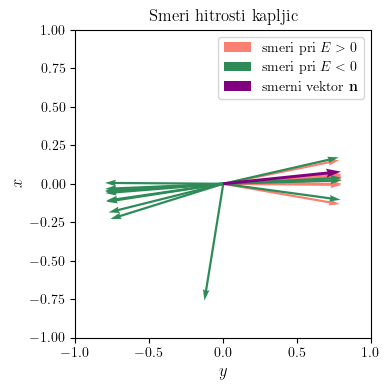

In [17]:
# Plot directions
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

ax.quiver(*(0*n_1), *n_1, scale=2.5, color='salmon', label=r'smeri pri $E > 0$')
ax.quiver(*(0*n_2), *n_2, scale=2.5, color='seagreen', label=r'smeri pri $E < 0$')
ax.quiver(*(0*n), *n, scale=2.5, color='purple', width =1e-2, label='smerni vektor $\mathbf n$')

ax.set_title(f'Smeri hitrosti kapljic')
ax.set_xlabel(r'$y$')
ax.set_ylabel(r'$x$')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.legend()
fig.tight_layout()
fig.savefig(f'v-directions.pdf')

$98.6$ & $-43.6$ & $520$ & $0.03$ \\
$95.0$ & $-30.7$ & $562$ & $0.08$ \\
$92.2$ & $-23.2$ & $583$ & $0.08$ \\
$24.7$ & $22.2$ & $480$ & $1.28$ \\
$120.7$ & $-88.1$ & $401$ & $1.43$ \\
$125.2$ & $-90.6$ & $412$ & $1.46$ \\
$66.5$ & $62.2$ & $796$ & $1.47$ \\
$97.8$ & $22.1$ & $768$ & $1.48$ \\
$91.4$ & $-30.5$ & $548$ & $1.52$ \\
$99.0$ & $-0.7$ & $696$ & $1.55$ \\
$102.1$ & $-54.3$ & $485$ & $1.63$ \\
$91.1$ & $-30.9$ & $544$ & $1.67$ \\
$25.8$ & $17.5$ & $462$ & $1.84$ \\
$93.5$ & $-5.3$ & $659$ & $1.95$ \\


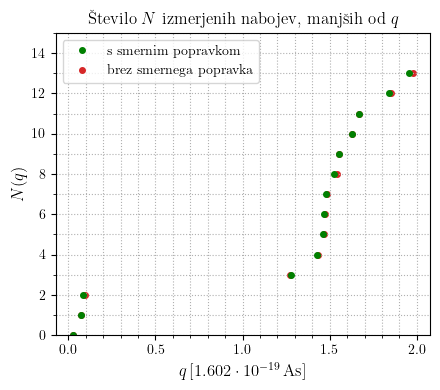

In [24]:
from matplotlib.ticker import AutoMinorLocator

# Velocity, corrected by projecting onto direction n
v_n1 = np.sum(v_1.T * n, axis=1)
v_n2 = np.sum(v_2.T * n, axis=1)

E = U/d
r = np.sqrt(9/4 * η_zr/g * (v_n1 + v_n2) / (ρ - ρ_zr))
q = 3*np.pi*η_zr * r/E * (v_n1 - v_n2)
N = np.arange(len(q))
q.sort()
for row in zip(v_n1, v_n2, r, q/q_0_theor):
    print(f'${1e6 * row[0]:.1f}$ & ${1e6 * row[1]:.1f}$ & ${1e9 * row[2]:.0f}$ & ${row[3]:.2f}$ \\\\')

# Plot
fig, ax = plt.subplots(1, 1, figsize=[4.5, 4])

ax.plot(q / q_0_theor, N, color='green',linestyle='', marker='o', markersize=4, label='s smernim popravkom')

# Velocity, uncorrected
v_n1 = np.sqrt(np.sum(v_1**2, axis=0))
v_n2 = np.sign(Δx_2) * np.sqrt(np.sum(v_2**2, axis=0))

E = U/d
r = np.sqrt(9/4 * η_zr/g * (v_n1 + v_n2) / (ρ - ρ_zr))
q = 3*np.pi*η_zr * r/E * (v_n1 - v_n2)
N = np.arange(len(q))
q.sort()

ax.plot(q / q_0_theor, N, color='tab:red', linestyle='', marker='o', markersize=4, zorder=-1, label='brez smernega popravka')

ax.set_title(f'Število $N$ izmerjenih nabojev, manjših od $q$')
ax.set_xlabel(r'$q\,[1.602 \cdot 10^{-19}\,\mathrm{As}]$')
ax.set_ylabel(r'$N(q)$')
ax.set_ylim(0, 15)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.grid(which='both', linestyle=':', axis='both')
ax.legend()
fig.tight_layout()
fig.savefig(f'N-by-q.pdf')